In [11]:

import numpy as np
import torch
from rocket import Rocket
# from TestNetwork import ActorCritic
# from PPO_network import VNetwork, PolicyNetwork
import matplotlib.pyplot as plt
import utils
import os
import glob
import time
import datetime
from collections import deque
import torch.optim as optim
import random

import torch.nn as nn

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:

class PositionalMapping(nn.Module):
    """
    Positional mapping Layer.
    This layer map continuous input coordinates into a higher dimensional space
    and enable the prediction to more easily approximate a higher frequency function.
    See NERF paper for more details (https://arxiv.org/pdf/2003.08934.pdf)
    """

    def __init__(self, input_dim, L=5, scale=1.0):
        super(PositionalMapping, self).__init__()
        self.L = L
        self.output_dim = input_dim * (L*2 + 1)
        self.scale = scale

    def forward(self, x):

        x = x * self.scale

        if self.L == 0:
            return x

        h = [x]
        PI = 3.1415927410125732
        for i in range(self.L):
            x_sin = torch.sin(2**i * PI * x)
            x_cos = torch.cos(2**i * PI * x)
            h.append(x_sin)
            h.append(x_cos)

        return torch.cat(h, dim=-1) / self.scale

# Based on the code from https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/
# Network architecture and hyperparameters are based on : https://arxiv.org/pdf/2006.05990.pdf
# The code below is taken from: https://github.com/huggingface/deep-rl-class/blob/main/notebooks/unit8/unit8_part1.ipynb


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class NetworkLayer(nn.Module):
    def __init__(self, input_dim, output_dim) -> None:
        super().__init__()
        self.mapping = PositionalMapping(input_dim=input_dim, L=7)
        self.layer = nn.Sequential(
            layer_init(nn.Linear(self.mapping.output_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, output_dim), std=1.0),
        )
    def forward(self, x):
        x = x.view([1, -1])
        x =  self.mapping(x)
        x = self.layer(x)
        return x

class VNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.mapping = PositionalMapping(input_dim=input_dim, L=7)
        self.critic = nn.Sequential(
            layer_init(nn.Linear(self.mapping.output_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
    def forward(self, x):
        x = x.view([1, -1])
        x = self.mapping(x)
        x = self.critic(x)
        return x


class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.mapping = PositionalMapping(input_dim=input_dim, L=7)
        self.actor = nn.Sequential(
            layer_init(nn.Linear(self.mapping.output_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, output_dim), std=1.0),
        )
        
    def forward(self, x):
        x = x.view([1, -1])
        x = self.mapping(x)
        x = self.actor(x)
        x = torch.nn.functional.softmax(x, dim=-1)
        return x


def gen_episode(environment, policy_target, device, max_step = 800):
    states = []
    actions = []
    rewards = []
    ratios = []
    state = environment.reset() 
    terminated = False

    eps = 0.01

    for step in range(max_step):
        probs_target = policy_target(torch.FloatTensor(state).to(device))
        if random.random() < eps:  # exploration
            action = random.randint(0, environment.action_dims - 1)
        else:
            action = torch.multinomial(probs_target, 1).item()
        
        next_state, reward, terminated, _ = environment.step(action) 
        #must add:
#         env.render()
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        if terminated:
            break  
        
        state = next_state
    return states, actions, rewards


In [9]:
task = 'landing'  # 'hover' or 'landing'
version = 5

max_m_episode = 200000
max_steps = 800
     #network and optimizer

    #hyperparameters:
alpha = 2.5e-4
gamma = 0.99
lmbda         = 0.99
eps_clip      = 0.2
K_epoch       = 4
entropy_coeff = 0.05
SAVE_INTERVAL = 1000
env = Rocket(task=task, max_steps=max_steps)


    #create networks:
pi = PolicyNetwork(env.state_dims, env.action_dims)
pi_optimizer = torch.optim.Adam(pi.parameters(), lr=alpha)
pi_target = PolicyNetwork(env.state_dims, env.action_dims)

V = VNetwork(env.state_dims)
V_optimizer = torch.optim.Adam(V.parameters(), lr=alpha)  

V = V.to(device)
pi = pi.to(device)
pi_target = pi_target.to(device)

    
ckpt_folder = os.path.join('./', task + '_ckpt')
if not os.path.exists(ckpt_folder):
    os.mkdir(ckpt_folder)

In [10]:
episode = 0
MAX_EPISODES = 20000
reward_history =[]
# update_times = []
reward_history_100 = deque(maxlen=100)

t1 = datetime.datetime.now()

while episode < MAX_EPISODES:  # episode loop
        
    pi_target.load_state_dict(pi.state_dict())
    states, actions, rewards = gen_episode(env, pi_target, device, max_steps)
            
    episode += 1    
    t2 = datetime.datetime.now()
    for k in range(1,K_epoch):
        loss1 = 0
        loss2 = 0
        entropy_mean = 0
        GAE = 0
        G = 0
        for t in range(len(states) - 2, -1, -1):
            S = states[t]
            A = actions[t]
            R = rewards[t]
            S_next = states[t+1]
                
            S=torch.FloatTensor(S).to(device)
            A=torch.tensor(A, dtype=torch.int8).to(device)
            S_next=torch.FloatTensor(S_next).to(device)
                
            with torch.no_grad():
                delta = R + gamma*V(S_next)-V(S)
                GAE = gamma * lmbda * GAE + delta           
                G = gamma * G + R


            actor_output = pi(S)
            actor_target_output = pi_target(S)
            actor_output = actor_output.view(-1).to(device)
            actor_target_output = actor_target_output.view(-1).to(device)
            
            entropy_mean -= torch.distributions.Categorical(probs=actor_output).entropy()
                
                # ratio = pi(S)[A]/pi_target(S)[A]
            ratio = actor_output[A] / actor_target_output[A]
                # print("ratio:", ratio)
            surr1 = ratio * (gamma**t)* GAE
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * (gamma**t)* GAE 
            loss1 = loss1 - torch.min(surr1, surr2)
            loss2 = loss2 + (G - V(S))**2
        loss1 = (loss1 + entropy_coeff * entropy_mean)/len(states)
        loss2 = loss2/len(states)
                
        pi_optimizer.zero_grad()
        loss1.backward()
        pi_optimizer.step()
            
        V_optimizer.zero_grad()
        loss2.backward()
        V_optimizer.step() 
    t3 = datetime.datetime.now()

    # print("Time for one update:", t3 - t2)
    
    reward_history.append(G)
        
    t4 = datetime.datetime.now()

    if episode % 1000 == 1:
        print('episode id: %d, episode return: %.3f'
                % (episode, G))
        # torch.save({'episode_id': episode,
        #                     # 'REWARDS': reward_history,
        #                     'model_pi_state_dict': pi.state_dict(),
        #                     'model_V_state_dict': V.state_dict(),
        #                     'model_pi_optimizer': pi_optimizer.state_dict(),
        #                     'model_V_optimizer': V_optimizer.state_dict()},
        #                    os.path.join(ckpt_folder, 'ckpt_' + str(version).zfill(8) + '.pt'))
        plt.figure()
        plt.plot(reward_history), plt.plot(utils.moving_avg(reward_history, N=50))
        plt.legend(['episode reward', 'moving avg'], loc=2)
        plt.xlabel('m episode')
        plt.ylabel('return')
        plt.savefig(os.path.join(ckpt_folder, 'rewards_' + str(version).zfill(8) + '.jpg'))
        plt.close()

    
    if episode % SAVE_INTERVAL == 0:
        torch.save({'episode_id': episode,
                            # 'REWARDS': reward_history,
                            'model_pi_state_dict': pi.state_dict(),
                            'model_V_state_dict': V.state_dict(),
                            'model_pi_optimizer': pi_optimizer.state_dict(),
                            'model_V_optimizer': V_optimizer.state_dict()},
                            os.path.join(ckpt_folder, 'ckpt_' + str(SAVE_INTERVAL).zfill(8) + '.pt'))
    t5 = datetime.datetime.now()
    print("Save Time:", t5 - t4)


t6 = datetime.datetime.now()
    

NameError: name 'random' is not defined

In [ ]:
print("Total Training Time:", t6 - t1)

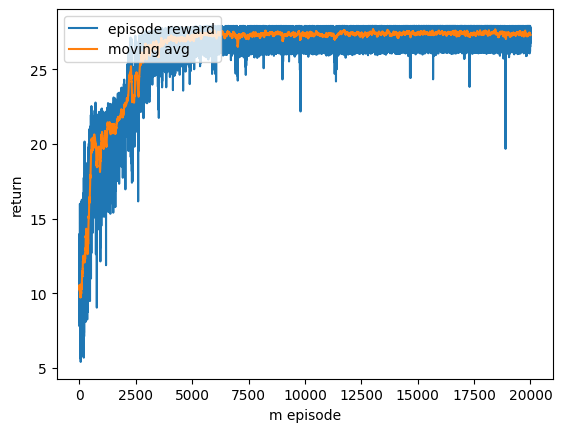

In [5]:
plt.plot(reward_history), plt.plot(utils.moving_avg(reward_history, N=50))
plt.legend(['episode reward', 'moving avg'], loc=2)
plt.xlabel('m episode')
plt.ylabel('return')
plt.show()

In [8]:
task = 'hover'  # 'hover' or 'landing'
max_steps = 800
gamma = 0.99
ckpt_dir = glob.glob(os.path.join(task+'_ckpt', '*.pt'))[-1]  # last ckpt

print(ckpt_dir)
env_test = Rocket(task=task, max_steps=max_steps)
pi_test = PolicyNetwork(env_test.state_dims, env_test.action_dims)
pi_test = pi_test.to(device)
    
if os.path.exists(ckpt_dir):
    checkpoint = torch.load(ckpt_dir, map_location=torch.device(device))
    pi_test.load_state_dict(checkpoint['model_pi_state_dict'])

state = env_test.reset()
episode_returns = list()
for i in range(100):
    _, _, rewards = gen_episode(env_test, pi_test, device, max_steps)
    G = 0
    for t in range(len(rewards) - 2, -1, -1):
        R = rewards[t]
        G = gamma * G + R

    episode_returns.append(G)

average_return = sum(episode_returns) / len(episode_returns)
print(average_return / 17)

hover_ckpt/ckpt_00000005.pt
1.6152465313460591
